# Deep learning for text and sequences

This chapter covers:
* Preprocessing text data into useful
representations
* Working with recurrent neural networks
* Using 1D convnets for sequence processing

## Working with text data

Deep-learning models don’t take as input raw text:
they only work with numeric tensors. Vectorizing text is the process of transforming text
into numeric tensors. This can be done in multiple ways:

* Segment text into words, and transform each word into a vector.
* Segment text into characters, and transform each character into a vector.
* Extract n-grams of words or characters, and transform each n-gram into a vector.

### One-hot encoding of words and characters

In [1]:
# Word-level one-hot encoding
import numpy as np 

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}

for sample in samples:
  for word in sample.split():
    if word not in token_index:
      token_index[word] = len(token_index) + 1 # assigns a unique index to each unique word.  
                                               # Note that you don't attribute index 0 to anything.


max_length = 10 # vectorizes the samples. You'll only consider the first max_len words in each sample.

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1) # this is where you store the results.
                  )

for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)
    results[i, j, index] = 1.

print(results)

[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


In [2]:
# Character-level one-hot encoding 
import string 

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# all printable ASCII characters 
characters = string.printable

token_index = dict(zip(range(1, len(characters)+1), characters))

max_length = 50 

results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))

for i, sample in enumerate(samples):
  for j, character in enumerate(sample):
    index = token_index.get(character)
    results[i, j, index] = 1.


print(results)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [3]:
'''
Note that Keras has built-in utilities for doing one-hot encoding of text at the word level
or character level, starting from raw text data. You should use these utilities, because
they take care of a number of important features such as stripping special characters
from strings and only taking into account the N most common words in your dataset
'''

# Using Keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer 

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Creates a tokenizer, configured 
# to only take into account the 1,000 most common words 
tokenizer = Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(samples) # build the word index

# turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# how you can recover the word index that was computed 
word_index = tokenizer.word_index

print(f'found {len(word_index)} unique tokens.')

found 9 unique tokens.


In [4]:
'''
A variant of one-hot encoding is the so-called one-hot hashing trick, which you can use
when the number of unique tokens in your vocabulary is too large to handle explicitly.
Instead of explicitly assigning an index to each word and keeping a reference of these
indices in a dictionary, you can hash words into vectors of fixed size.

*** which saves memory and allows online encoding of the data
'''

# Word-level one-hot encoding with hashing trick
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

'''
Stores the words as vectors of size 1,000. If you have close
to 1,000 words (or more), you’ll see many hash collisions,
which will decrease the accuracy of this encoding method
'''
dimensionality = 1000 
max_length = 10 

results = np.zeros((len(samples), max_length, dimensionality))

for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = abs(hash(word)) % dimensionality
    '''
    dimensionality : Hashes the word into a random integer index between 0 and 1000
    '''
    results[i, j, index] = 1.


print(results)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


### Using word embeddings 

Another popular and powerful way to associate a vector with a word is the use of dense word vectors, also called word embeddings. Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are lowdimensional floating-point vectors


In [5]:
from IPython import display
display.Image("./pic1.PNG")

* It’s thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It’s about learning the weights of a layer: the Embedding layer.

In [6]:
# instantiating an Embedding layer 
from keras.layers import Embedding 

'''
The embedding layer takes at least two arguments: 
  the number of possible tokens (here, 1000: 1 + maximum word index)
                      and
  the dimensionality of the embeddings (here, 64)
'''
embedding_layer = Embedding(1000, 64)

# The Embedding layer is best understood as a dictionary that maps integer indices
# (which stand for specific words) to dense vectors.

Word index  -> Embedding layer ->  Corresponding word vector

 * The EMBEDDING layer takes as input a 2D tensor of integers, of shape(samples, sequence_length), where each entry is a sequence of integers.

 * It can embed
sequences of variable lengths: for instance, you could feed into the Embedding layer in
the previous example batches with shapes (32, 10) (batch of 32 sequences of length
10) or (64, 15) (batch of 64 sequences of length 15).

* (because you need to pack them into a single tensor),
so sequences that are shorter than others should be padded with zeros, and sequences
that are longer should be truncated.

* This layer returns a
floating-point tensor of shape
3D
(samples, sequence_
_dimensionality, embedding_dimensionality). Such a
tensor can then be processed by
length, embedding_
3D
an
layer or a
convolution layer
RNN
1D

In [7]:
# Loading the IMDB data for use with an Embedding layer
from keras.datasets import imdb 
from keras import preprocessing 

max_features = 10000 #number of words to consider as features
maxlen = 20 # cuts off the text after this number of words(among the max_featurs most common words)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) # loads the data as lists of integers

# turns the lists of integers into 2D integer tensor of shape(samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step


In [8]:
# using an EMBEDDING layer and classifier on the IMDB data 
from keras.models import Sequential
from keras.layers import Flatten, Dense 

model = Sequential()
'''
Specifies the maximum input length to the Embedding layer 
so you can later flatten the embedded inputs. 
After the Embedding layer, the activations have shape (samples, maxlen, 8).
'''
model.add(Embedding(10000, 8, input_length=maxlen))

'''
Flattens the 3D tensor of embeddings into a 2D
tensor of shape (samples, maxlen * 8)
'''
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, 
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 6s 4ms/step - loss: 0.6614 - acc: 0.6380 - val_loss: 0.6066 - val_acc: 0.6946
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5321 - acc: 0.7512 - val_loss: 0.5219 - val_acc: 0.7306
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4579 - acc: 0.7881 - val_loss: 0.4981 - va

### USING PRETRAINED WORD EMBEDDINGS

* Sometimes, you have so little training data available that you can’t use your data alone to learn an appropriate task-specific embedding of your vocabulary

* Instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties—that captures generic aspects of language structure.

In [9]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  12.9M      0  0:00:06  0:00:06 --:--:-- 19.3M


In [10]:
!tar -xf aclImdb_v1.tar.gz

In [11]:
'''   ***Processing the labels of the raw IMDB data***'''
import os
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


In [12]:
len(labels)
len(texts)

25000

In [13]:
# Tokenizing the text of the raw IMDB data 

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np 

maxlen=100 # cuts off reviews after 100 words 
training_samples=200 # trains on 200 samples 
validation_samples=1000 # validates on 10,000 samples
max_words=10000 # consider only the top(most common) 10,000 words in the dataset 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)



In [14]:
sequences[:10]

[[13,
  11,
  3,
  209,
  39,
  13,
  9,
  3,
  450,
  10,
  891,
  11,
  730,
  31,
  2246,
  11,
  884,
  85,
  1,
  19,
  12,
  10,
  40,
  4716,
  359,
  13,
  1079,
  160,
  39,
  244,
  901,
  134,
  9,
  800,
  35,
  251,
  5,
  94,
  3,
  210,
  85,
  4,
  11,
  580,
  4,
  4939,
  209,
  39,
  450,
  1,
  1092,
  1321,
  2,
  3366,
  4588,
  68,
  413,
  134,
  10,
  241,
  3,
  562,
  8926,
  12,
  47,
  6,
  96,
  73,
  4311,
  1445,
  8,
  359,
  57,
  635,
  10,
  78,
  21,
  261,
  12,
  3657,
  2006,
  119,
  73,
  5,
  567,
  9,
  302,
  10,
  231,
  9,
  61,
  1280,
  50,
  7364,
  5,
  1,
  964,
  695,
  2847,
  8,
  11,
  19,
  13,
  5975,
  685,
  5,
  1,
  189,
  12,
  1,
  788,
  26,
  13,
  420,
  5,
  27,
  228,
  250,
  4,
  26,
  13,
  302,
  8595,
  2,
  4558,
  7476,
  1,
  528,
  12,
  68,
  420,
  5,
  27,
  618,
  68,
  817,
  2718,
  31,
  1,
  335,
  580,
  4,
  160,
  209,
  66,
  3,
  539,
  1117,
  16,
  11,
  19,
  18,
  1035,
  1,
  2588,
  6,
  48

In [15]:
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print(f'shape of data tensor: {data.shape}')
print(f'shape of label tensor: {labels.shape}')

Found 88582 unique tokens.
shape of data tensor: (25000, 100)
shape of label tensor: (25000,)


In [16]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples+validation_samples]
y_val = labels[training_samples: training_samples+validation_samples]

In [17]:
import requests
url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"

target_path = 'gloveee.zip'

response = requests.get(url, stream=True)
handle = open(target_path, "wb")
for chunk in response.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

In [18]:
import zipfile
with zipfile.ZipFile("gloveee.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

In [19]:
# Preprocessing the EMBEDDINGS 

    # Parsing the GloVe word-embeddings file 
glove_dir = './targetdir'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) # 100 dimension

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs


f.close()

print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


In [20]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
      # words not found in the embedding index will be all zeros 
      embedding_matrix[i] = embedding_vector 

In [21]:
# Model definition
from keras.models import Sequential 
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False 


In [23]:
# training and evaluation

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 56ms/step - loss: 0.1638 - acc: 0.8700 - val_loss: 1.2180e-05 - val_acc: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 31ms/step - loss: 3.8050e-07 - acc: 1.0000 - val_loss: 1.0521e-05 - val_acc: 1.0000
Epoch 3/10
7/7 [==============================] - 0s 17ms/step - loss: 2.6661e-07 - acc: 1.0000 - val_loss: 9.3750e-06 - val_acc: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 19ms/step - loss: 1.9728e-07 - acc: 1.0000 - val_loss: 8.4627e-06 - val_acc: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 17ms/step - loss: 1.5396e-07 - acc: 1.0000 - val_loss: 7.6139e-06 - val_acc: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 19ms/step - loss: 1.1860e-07 - acc: 1.0000 - val_loss: 7.0199e-06 - val_acc: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 17ms/step - loss: 9.6636e-08 - acc: 1.0000 - val_loss: 6.4892e-06 - val_acc: 1.0000
Epoch 8/10
7/7 [=============================

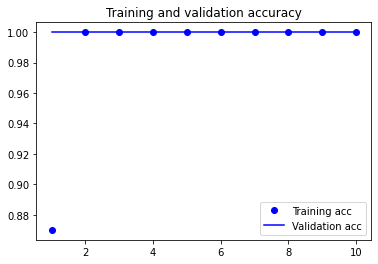

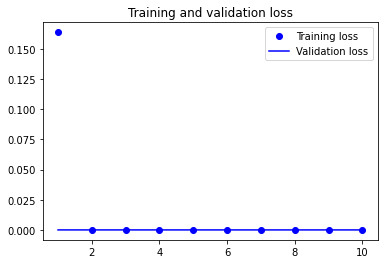

In [24]:
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Understanding recurrent neural networks

A recurrent neural network (RNN) adopts the same principle, albeit in an extremely
simplified version: it processes sequences by iterating through the sequence elements
and maintaining a state containing information relative
to what it has seen so far. In effect, an RNN is a type of
neural network that has an internal loop (see figure 6.9).
The state of the RNN is reset between processing two different,
independent sequences (such as two different
IMDB reviews), so you still consider one sequence a single
data point: a single input to the network. What
changes is that this data point is no longer processed in a
single step; rather, the network internally loops over
sequence elements.

* it considers its current state at
and the input at t (of shape (input_features,), and combines them to obtain the output at t. You’ll then set the state for the next step to be this previous output.

* For the first timestep, the previous output isn’t defined; hence, there is no current state. So, you’ll initialize the state as an all zero vector called the initial state of the network.

In [25]:
# Pseudocode RNN 
state_t = 0 # the state at t

for input_t in input_sentence:  # iterates over sequence elements
  output_t = f(input_t, state_t)
  
  # the previous output becomes the state for the next iteration
  state_t = output_t

NameError: ignored

In [ ]:
# More detailed pseudocode for the RNN 
state_t = 0

for input_t in input_sentence:
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = output_t

In [26]:
'''To make these notions absolutely unambiguous, 
let’s write a naive Numpy implementation of the forward pass of the simple RNN.'''

#Numpy implementation of a simple RNN 
import numpy as np 

timesteps=100 #number of timesteps in the input sequence
input_features=32 #dimensionality of the input feature space 
output_features=64 #dimensionality of the output feature space 

#input data: random noise for the sake of the example 
inputs = np.random.random((timesteps, input_features))

#initial state: an all-zero vector 
state_t = np.zeros((output_features,))

#create three random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

#input_t is a vector of shape(input_features,).
for input_t in inputs:
  #combines the input with the current state(the previous output) 
  #to obtain the current output
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

  #stores this output in a list 
  successive_outputs.append(output_t)
  
  #updates the state of the network for the next timestep
  state_t = output_t 

# the final output is 2D tensor of shape(timesteps, output_features).
final_output_sequence = np.concatenate(successive_outputs, axis=0)

* in summary, an RNN is a for loop that reuses quantities computed
during the previous iteration of the loop, nothing more. Of course, there are many
different RNNs fitting this definition that you could build—this example is one of the
simplest RNN formulations. 

In [27]:
# RNNs are characterized by their step function, such as the following function in this case
# output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

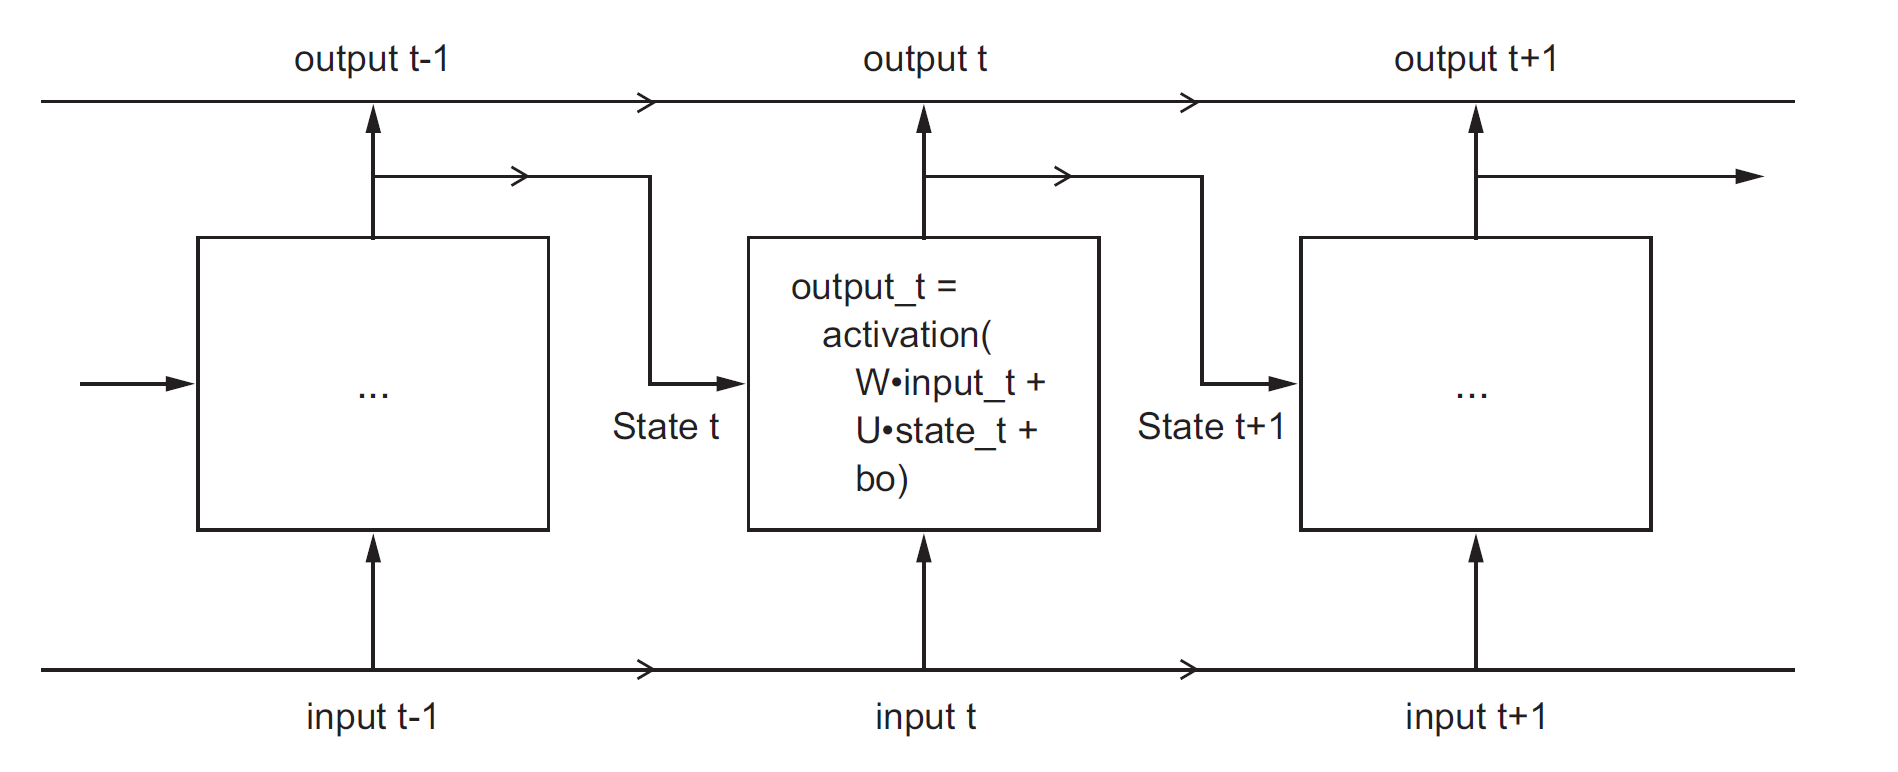

In [28]:
from IPython import display
display.Image("./pic2.PNG")

# A simple RNN, unrolled over time

### A recurrent layer in Keras 

The process you just naively implemented in Numpy corresponds to an actual Keras
layer—the SimpleRNN layer

In [29]:
from keras.models import Sequential 
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [30]:
# example returns the full state sequence:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [31]:
'''
It’s sometimes useful to stack several recurrent layers one after the other in order to
increase the representational power of a network. In such a setup, you have to get all
of the intermediate layers to return full sequence of outputs:
'''
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) # last layer only returns the last output

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [32]:
'''Now, let’s use such a model on the IMDB movie-review-classification problem. First,
preprocess the data.'''
from keras.datasets import imdb
from keras.preprocessing import sequence

#number of words to consider as features
max_features = 10000

#cuts off texts after this many words(among the max_features most common words)
maxlen = 500
batch_size = 32

print('Loading data...')

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [33]:
'''Let’s train a simple recurrent network using an Embedding layer and a SimpleRNN
layer.'''

#Training the model with Embedding and SimpleRNN layers

from keras.layers import Dense 
model=Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
 92/157 [================>.............] - ETA: 40s - loss: 0.6712 - acc: 0.5778

KeyboardInterrupt: ignored

In [ ]:
# plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* As a reminder, in chapter 3, the first naive approach to this dataset got you to a test
accuracy of 88%. Unfortunately, this small recurrent network doesn’t perform well
compared to this baseline (only 85% validation accuracy). Part of the problem is that
your inputs only consider the first 500 words, rather than full sequences—hence, the
has access to less information than the earlier baseline model. The remainder of
RNN
the problem is that
isn’t good at processing long sequences, such as text
SimpleRNN

* Other types of recurrent layers perform much better. Let’s look at some moreadvanced
layers.

# Understanding the LSTM and GRU layers

* Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it.


* Let’s add to this picture an additional data flow that carries information across timesteps.
Call its values at different timesteps Ct, where C stands for carry. This information
will have the following impact on the cell: it will be combined with the input
connection and the recurrent connection (via a dense transformation: a dot product
with a weight matrix followed by a bias add and the application of an activation function),
and it will affect the state being sent to the next timestep (via an activation
function an a multiplication operation). Conceptually, the carry dataflow is a way to
modulate the next output and the next state

In [ ]:
display.Image("./pic3.PNG")

In [ ]:
'''Now the subtlety: the way the next value of the carry dataflow is computed. It involves
three distinct transformations. All three have the form of a SimpleRNN cell:'''
y = activation(dot(state_t, U) + dot(input_t, W) + b)

'''But all three transformations have their own weight matrices, 
which you’ll index with the letters i, f, and k. 
Here’s what you have so far (it may seem a bit arbitrary, but bear
with me).'''

In [ ]:
#Pseudocode details of the LSTM architecture (1/2)
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

#But all three transformations have their own weight matrices!!!!!!!!!!!!!!
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

* !!!!You obtain the new carry state (the next c_t) by combining i_t, f_t, and k_t !!!!


In [ ]:
#Pseudocode details of the LSTM architecture (2/2)
c_t+1 = i_t * k_t * c_t * f_t

In [ ]:
display.Image("./pic4.PNG")

* Multiplying c_t and f_t is a way to deliberately forget irrelevant information in the carry dataflow. 

* Meanwhile, i_t and k_t provide information about the present, updating the carry track with new information.

In [ ]:
#Using the LSTM layer in Keras
from keras.layers import LSTM

model = Sequential()

model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

## Advanced use of recurrent neural networks
In this section, we’ll review three advanced techniques for improving the performance
and generalization power of recurrent neural networks. By the end of the section,
you’ll know most of what there is to know about using recurrent networks with
Keras.

We’ll cover the following techniques:

* Recurrent dropout—This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.

* Stacking recurrent layers—This increases the representational power of the network (at the cost of higher computational loads).

* Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.


### A temperature-forecasting problem

* Sequence data is found in many more problems
than just language processing. In all the examples in this section, you’ll play with a
weather timeseries dataset recorded at the Weather Station at the Max Planck Institute
for Biogeochemistry in Jena, Germany.

* In this dataset, 14 different quantities (such air temperature, atmospheric pressure,
humidity, wind direction, and so on) were recorded every 10 minutes, over several
years. The original data goes back to 2003, but this example is limited to data
from 2009–2016. This dataset is perfect for learning to work with numerical
timeseries. You’ll use it to build a model that takes as input some data from the recent
past (a few days’ worth of data points) and predicts the air temperature 24 hours in
the future.

In [34]:
!curl -O  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.9M  100 12.9M    0     0  9199k      0  0:00:01  0:00:01 --:--:-- 9199k


In [35]:
import zipfile
with zipfile.ZipFile("jena_climate_2009_2016.csv.zip","r") as zip_ref:
    zip_ref.extractall("jena_climate")

In [36]:
!mkdir jena_climate

mkdir: cannot create directory ‘jena_climate’: File exists


In [37]:
# Inspecting the data of the Jena weather dataset

import os 

data_dir= './jena_climate'
fname= os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines= data.split('\n')
header= lines[0].split(',')
lines= lines[1:]

print(header)
print('')
print(f'len of header : {len(header)} ')
print('')
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

len of header : 15 

420451


In [38]:
# convert all 420,551 lines of data into a Numpy array.

# Parsing the data 
import numpy as np 
float_data = np.zeros((len(lines), len(header)-1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values

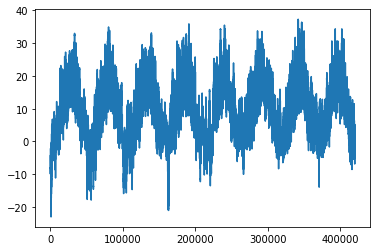

In [39]:
'''here is the plot of temperature (in degrees Celsius) over time. 
On this plot, you can clearly see the yearly periodicity of temperature.'''

from matplotlib import pyplot as plt

temp = float_data[:, 1] # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

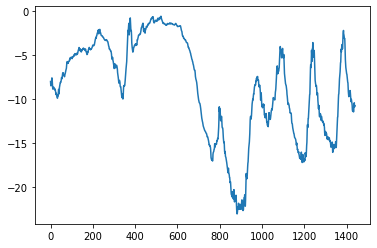

In [40]:
'''Here is a more narrow plot of the first 10 days of temperature data.
Because the data is recorded every 10 minutes, you get 144 data points per day.'''

plt.plot(range(1440), temp[:1440])

### Preparing the data
The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps? You’ll use the following parameter values:

* lookback = 720—Observations will go back 5 days.
* steps = 6—Observations will be sampled at one data point per hour.
* delay = 144—Targets will be 24 hours in the future.


To get started, you need to do two things:
* Preprocess the data to a format a neural network can ingest. This is easy: the
data is already numerical, so you don’t need to do any vectorization. But each
timeseries in the data is on a different scale (for example, temperature is typically
between -20 and +30, but atmospheric pressure, measured in mbar, is
around 1,000). You’ll normalize each timeseries independently so that they all
take small values on a similar scale.

* Write a Python generator that takes the current array of float data and yields
batches of data from the recent past, along with a target temperature in the
future. Because the samples in the dataset are highly redundant (sample N and
sample N + 1 will have most of their timesteps in common), it would be wasteful
to explicitly allocate every sample. Instead, you’ll generate the samples on the
fly using the original data.

In [41]:
'''You’ll preprocess the data by subtracting the mean of each timeseries and dividing by
the standard deviation. You’re going to use the first 200,000 timesteps as training data,
so compute the mean and standard deviation only on this fraction of the data.'''

# Normalizing the data 
mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std 

* It takes the following arguments:

  * data—The original array of floating-point data, which you normalized in listing 6.32.

  * lookback—How many timesteps back the input data should go.

  * delay—How many timesteps in the future the target should be.

  * min_index and max_index—Indices in the data array that delimit which timesteps
  to draw from. This is useful for keeping a segment of the data for validation
  and another for testing.

  * shuffle—Whether to shuffle the samples or draw them in chronological order.

  * batch_size—The number of samples per batch.

  * step—The period, in timesteps, at which you sample data. You’ll set it to 6 in
  order to draw one data point every hour.

In [42]:
#Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
  
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
                              min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]

    yield samples, targets

* Now, let’s use the abstract generator function to instantiate three generators: one for
training, one for validation, and one for testing. Each will look at different temporal
segments of the original data: the training generator looks at the first 200,000 timesteps,
the validation generator looks at the following 100,000, and the test generator
looks at the remainder.

In [49]:
# Preparing the training, validation, and test generators
lookback= 1440 
step= 6
delay= 144
batch_size= 128 

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

# how many steps to draw from val_gen in order to see the entire validation set 
val_steps = (300000 - 200001 - lookback)

# how many steps to draw from test_gen in order to see the entire test set 
test_steps = (len(float_data) - 300001 - lookback)


### A common-sense, non-machine-learning baseline

In [44]:
# Here’s the evaluation loop.

# computing the common sense baseline MAE 
def evaluate_naive_method():
  batch_maes= []

  for step in range(val_steps):
    samples, targets= next(val_gen)
    preds= samples[:, -1, 1]
    mae= np.mean(np.abs(preds-targets))
    batch_maes.append(mae)

  print(np.mean(batch_maes))

evaluate_naive_method()

KeyboardInterrupt: ignored

This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable.

It translates to an average absolute error of 0.29 × temperature_std degrees
Celsius: 2.57°C.

In [45]:
# Converting the MAE back to a Celsius error
celsius_mae = 0.29 * std[1]
celsius_mae

2.216925247668638

### A basic machine-learning approach

In [51]:
from keras.models import Sequential 
from keras import layers 
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

model= Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history= model.fit_generator(train_gen, 
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
498/500 [============================>.] - ETA: 0s - loss: 1.6129

KeyboardInterrupt: ignored

In [ ]:
# Plotting results
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### A first recurrent baseline

In [53]:
# Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model= Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history= model.fit(train_gen, 
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.3449

KeyboardInterrupt: ignored

### Using recurrent dropout to fight overfitting

In [55]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
          dropout=0.2,
          recurrent_dropout=0.2,
          input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fe6abfbbd40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fe6abfbbd40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


500/500 [==============================] - ETA: 0s - loss: 0.3823

KeyboardInterrupt: ignored

### Stacking recurrent layers

* you’re no longer overfitting but seem to have hit a performance bottleneck,
you should consider increasing the capacity of the network.

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model

model = Sequential()
model.add(layers.GRU( 32,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

### Using bidirectional RNNs

In [56]:
# Training and evaluating an LSTM using reversed sequences

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [57]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 20s 113ms/step - loss: 0.4944 - acc: 0.7599 - val_loss: 0.4074 - val_acc: 0.8308
Epoch 2/10
157/157 [==============================] - 17s 111ms/step - loss: 0.3089 - acc: 0.8813 - val_loss: 0.3096 - val_acc: 0.8778
Epoch 3/10
157/157 [==============================] - 17s 112ms/step - loss: 0.2494 - acc: 0.9084 - val_loss: 0.3097 - val_acc: 0.8838
Epoch 4/10
157/157 [==============================] - 17s 108ms/step - loss: 0.2152 - acc: 0.9232 - val_loss: 0.3443 - val_acc: 0.8804
Epoch 5/10
157/157 [==============================] - 17s 106ms/step - loss: 0.1911 - acc: 0.9291 - val_loss: 0.4209 - val_acc: 0.8476
Epoch 6/10
157/157 [==============================] - 17s 106ms/step - loss: 0.1701 - acc: 0.9390 - val_loss: 0.4139 - val_acc: 0.8230
Epoch 7/10
157/157 [==============================] - 17s 106ms/step - loss: 0.1520 - acc: 0.9463 - val_loss: 0.3800 - val_acc: 0.8546
Epoch 8/10
157/157 [==============================] - 1

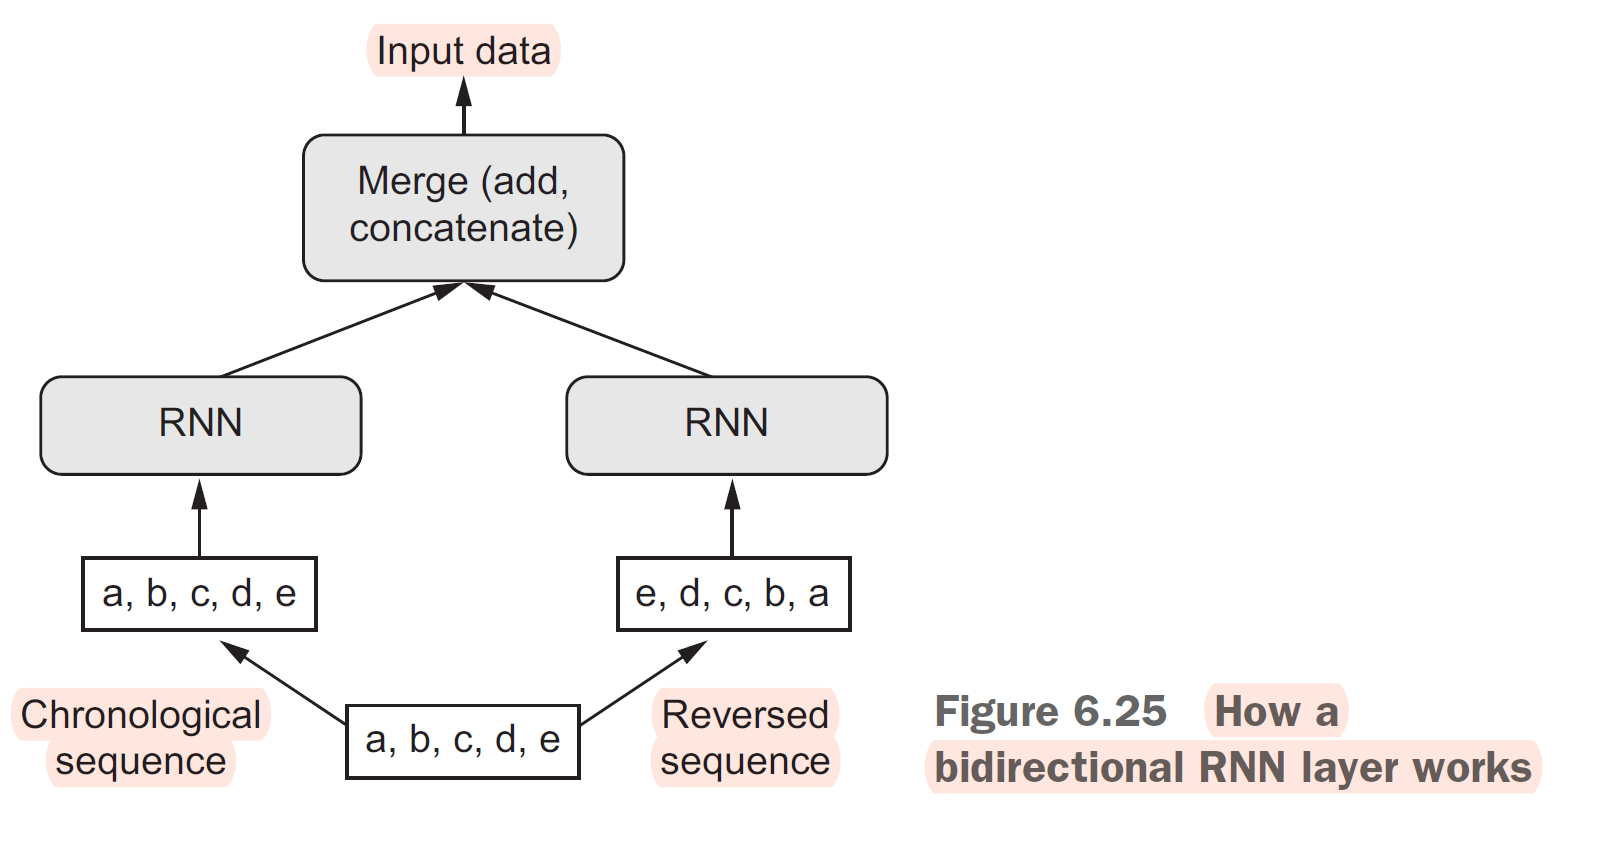

In [58]:
display.Image("./pic5.PNG")

In [59]:
# Training and evaluating a bidirectional LSTM
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 41s 237ms/step - loss: 0.5448 - acc: 0.7191 - val_loss: 0.8043 - val_acc: 0.6172
Epoch 2/10
157/157 [==============================] - 37s 235ms/step - loss: 0.3356 - acc: 0.8666 - val_loss: 0.4470 - val_acc: 0.7870
Epoch 3/10
157/157 [==============================] - 36s 231ms/step - loss: 0.2724 - acc: 0.8978 - val_loss: 0.3477 - val_acc: 0.8548
Epoch 4/10
157/157 [==============================] - 36s 231ms/step - loss: 0.2283 - acc: 0.9178 - val_loss: 0.4259 - val_acc: 0.8280
Epoch 5/10
157/157 [==============================] - 36s 229ms/step - loss: 0.2064 - acc: 0.9283 - val_loss: 0.7062 - val_acc: 0.7730
Epoch 6/10
157/157 [==============================] - 36s 229ms/step - loss: 0.1789 - acc: 0.9374 - val_loss: 0.4803 - val_acc: 0.8650
Epoch 7/10
157/157 [==============================] - 36s 229ms/step - loss: 0.1659 - acc: 0.9428 - val_loss: 0.3756 - val_acc: 0.8566
Epoch 8/10
157/157 [==============================] - 3

In [ ]:
# Training a bidirectional GRU

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

## Sequence processing with convnets

In [63]:
# Preparing the IMDB data

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [65]:
# Training and evaluating a simple 1D convnet on the IMDB data

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


157/157 [==============================] - 30s 25ms/step - loss: 0.7260 - acc: 0.5263 - val_loss: 0.6854 - val_acc: 0.5554
Epoch 2/10
157/157 [==============================] - 4s 22ms/step - loss: 0.6653 - acc: 0.6858 - val_loss: 0.6670 - val_acc: 0.6648
Epoch 3/10
157/157 [==============================] - 4s 23ms/step - loss: 0.6278 - acc: 0.7692 - val_loss: 0.6274 - val_acc: 0.7234
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.5553 - acc: 0.8144 - val_loss: 0.5273 - val_acc: 0.8004
Epoch 5/10
157/157 [==============================] - 4s 23ms/step - loss: 0.4350 - acc: 0.8495 - val_loss: 0.4380 - val_acc: 0.8280
Epoch 6/10
157/157 [==============================] - 4s 23ms/step - loss: 0.3531 - acc: 0.8738 - val_loss: 0.4328 - val_acc: 0.8400
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 0.3017 - acc: 0.8924 - val_loss: 0.4009 - val_acc: 0.8590
Epoch 8/10
157/157 [==============================] - 4s 22ms/step - loss: 0.26

In [ ]:
# Combining CNNs and RNNs to process long sequences

model = Sequential()

model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
498/500 [============================>.] - ETA: 0s - loss: 0.4850